# Active Learning Experiments

### What is active learning
Active learning is a machine learning setting where the learning algorithm decides what data to be labeled.
### Why active learning
The key idea behind active learning is that a machine learning algorithm can
achieve greater accuracy with fewer training labels if it is allowed to choose the
data from which it learns. An active learner may pose queries, usually in the form
of unlabeled data instances to be labeled by an oracle (e.g., a human annotator).
Active learning is well-motivated in many modern machine learning problems,
where unlabeled data may be abundant or easily obtained, but labels are difficult,
time-consuming, or expensive to obtain.

### Let's get started

In [1]:
# Some constants for dataset size and stroke paddings
STROKE_COUNT = 196
TRAIN_SAMPLES = 50
VALID_SAMPLES = 50
TEST_SAMPLES = 50
POOL_SAMPLES = 250

### Load libraries and some utility plot functions

In [2]:
%matplotlib inline
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import pandas as pd
from keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout
from keras import backend as K
from glob import glob
import gc
gc.enable()
from IPython.display import clear_output

def plot_history(history):
    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_learn_process(process):
    plt.plot(process["Percentage"], process["Accuracy"])
    plt.title('Accuracy/Percentage')
    plt.xlabel('percentage of data used')
    plt.ylabel('accuracy on test data')
    plt.show()
    
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
if len(get_available_gpus())>0:
    from keras.layers import CuDNNLSTM as LSTM # this one is about 3x faster on GPU instances  
base_dir = os.path.join('..', 'input', 'quickdraw-doodle-recognition')
# base_dir = os.path.join('..', 'input')
test_path = os.path.join(base_dir, 'test_simplified.csv')
inline_process_template = "../input/learning-process-inline/{}"

Using TensorFlow backend.


### Load the dataset and preprocess the input

In [3]:
from ast import literal_eval
ALL_TRAIN_PATHS = glob(os.path.join(base_dir, 'train_simplified', '*.csv'))
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

def _stack_it(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)  
     for i,(x,y) in enumerate(stroke_vec) 
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=STROKE_COUNT, 
                         padding='post').swapaxes(0, 1)
def read_batch(samples=5, 
               start_row=0,
               max_rows = 1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for c_path in ALL_TRAIN_PATHS:
        c_df = pd.read_csv(c_path, nrows=max_rows, skiprows=start_row)
        c_df.columns=COL_NAMES
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].\
        map(_stack_it)
    
    return full_df

def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y

### Here are class labels for the Quick Draw Game

In [4]:
train_args = dict(samples=TRAIN_SAMPLES, 
                  start_row=0, 
                  max_rows=TRAIN_SAMPLES)
pool_args = dict(samples=POOL_SAMPLES, 
                 start_row=train_args['max_rows'], 
                 max_rows=POOL_SAMPLES)
valid_args = dict(samples=VALID_SAMPLES, 
                  start_row=train_args['max_rows']+pool_args['max_rows'], 
                  max_rows=VALID_SAMPLES)
test_args = dict(samples=TEST_SAMPLES, 
                 start_row=train_args['max_rows']+valid_args['max_rows']+pool_args['max_rows'], 
                 max_rows=TEST_SAMPLES)

train_df = read_batch(**train_args)
valid_df = read_batch(**valid_args)
test_df = read_batch(**test_args)
pool_df = read_batch(**pool_args)
word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])
print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))

words 340 => The Eiffel Tower, The Great Wall of China, The Mona Lisa, airplane, alarm clock, ambulance, angel, animal migration, ant, anvil, apple, arm, asparagus, axe, backpack, banana, bandage, barn, baseball, baseball bat, basket, basketball, bat, bathtub, beach, bear, beard, bed, bee, belt, bench, bicycle, binoculars, bird, birthday cake, blackberry, blueberry, book, boomerang, bottlecap, bowtie, bracelet, brain, bread, bridge, broccoli, broom, bucket, bulldozer, bus, bush, butterfly, cactus, cake, calculator, calendar, camel, camera, camouflage, campfire, candle, cannon, canoe, car, carrot, castle, cat, ceiling fan, cell phone, cello, chair, chandelier, church, circle, clarinet, clock, cloud, coffee cup, compass, computer, cookie, cooler, couch, cow, crab, crayon, crocodile, crown, cruise ship, cup, diamond, dishwasher, diving board, dog, dolphin, donut, door, dragon, dresser, drill, drums, duck, dumbbell, ear, elbow, elephant, envelope, eraser, eye, eyeglasses, face, fan, feathe

In [5]:
train_data = get_Xy(train_df)
pool_data = get_Xy(pool_df)
val_data = get_Xy(valid_df)
test_data = get_Xy(test_df)

## Set up the LSTM model
The quick draw recognizing sequence model is used to experiment with the active learning techniques.

[Quick, Draw](https://quickdraw.withgoogle.com/) is a game made by Google AI to gather drawing dataset from the public for machine leaning research and the collected datasets are made public

The network structure used here is the same one used in tensorflow sequence [tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent_quickdraw)

![quick draw model image](https://www.tensorflow.org/images/quickdraw_model.png)

In [6]:
stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape = (None, 3)))
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
stroke_read_model.add(Conv1D(48, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(64, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(96, (3,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = True))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = False))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(512))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
clear_output()

### Class active_learner is the main object handling all the logic
It loads the pretrained weight and also controls things like how many rounds of selections we do for active learning, how many unlabeled data we select during each round, etc.

In [7]:
class active_learner:
    def __init__(self, model, train, pool, val, test):
        self.model = model
        self.train = train
        self.pool = pool
        self.val = val
        self.test = test
        self.weight_path="../input/base-weight/{}_weights.best.hdf5".format('stroke_lstm_model')
#         self.weight_path="{}_weights.best.hdf5".format('stroke_lstm_model')
        checkpoint = ModelCheckpoint(self.weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
        reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, 
                                           verbose=1, mode='auto', cooldown=5, min_lr=0.0001)
        early = EarlyStopping(monitor="val_loss", 
                              mode="min", 
                              patience=3) # probably needs to be more patient, but kaggle time is limited
        self.callbacks_list = [checkpoint, reduceLROnPlat, early]
        self.__load_base()
    
    def __load_base(self, batch_size=4096):
        model = self.model
        weight_path = self.weight_path
        callbacks_list = self.callbacks_list
        train_x, train_y = self.train
        val_x, val_y = self.val
        
        try:
            model.load_weights(weight_path)
        except:
            history = model.fit(train_x, train_y,
                                validation_data = (val_x, val_y), 
                                batch_size = batch_size,
                                epochs = 500,
                                verbose = 0,
                                callbacks = callbacks_list[:-1])
            clear_output()
            plot_history(history.history)
            
    def learn(self, query_fn, prop=0.70, batch_size=4096, epoch_per_al_cycle=20, extra_label_per_epoch=200):
        self.__load_base()
        model = self.model
        train_x, train_y = self.train
        pool_x, pool_y = self.pool
        val_x, val_y = self.val
        test_x, test_y = self.test
        
        tot_size = len(train_x) + len(pool_x)
        cur_size = len(train_x)
        
        lstm_results = model.evaluate(test_x, test_y, batch_size = batch_size)
        print
        learn_process = {"Percentage":[], "Accuracy":[]}
        learn_process["Percentage"].append(cur_size/tot_size)
        learn_process["Accuracy"].append(100*lstm_results[1])
        
        while cur_size/tot_size < prop:
            rank = query_fn(model, pool_x)
            selected_x, selected_y = pool_x[rank[:extra_label_per_epoch]], pool_y[rank[:extra_label_per_epoch]]
            pool_x, pool_y = pool_x[rank[extra_label_per_epoch:]], pool_y[rank[extra_label_per_epoch:]]
            train_x, train_y = np.vstack((train_x, selected_x)), np.vstack((train_y, selected_y))
            
            model.fit(train_x, train_y, 
                      validation_data = (val_x, val_y), 
                      batch_size = batch_size, 
                      epochs=epoch_per_al_cycle, 
                      callbacks = self.callbacks_list[1: ],
                      verbose=0)
            cur_size = len(train_x)
#             print(cur_size/tot_size)
            lstm_results = model.evaluate(test_x, test_y, batch_size = batch_size, verbose=0)
            print("Test data accuracy is: ", 100*lstm_results[1])
            learn_process["Percentage"].append(cur_size/tot_size)
            learn_process["Accuracy"].append(100*lstm_results[1])
        
        return learn_process
    
    def evaluate(self):
        model = self.model
        test_x, test_y = self.test
        lstm_results = stroke_read_model.evaluate(test_x, test_y, batch_size = 4096)
        print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[1], 100*lstm_results[2]))

In [8]:
learner = active_learner(stroke_read_model, train_data, pool_data, val_data, test_data)

We can evaluate our current model and see how well it does on the test dataset.

In [9]:
learner.evaluate()

17000/17000 [==============================] - 34s 2ms/step
Accuracy: 0.5%, Top 3 Accuracy 1.3%


### There're different scenarios of active learning; We only experiment with pool-based here.
Generally, pool-based active learning algorithm follows this simple pattern:
```
Given: Labeled set L, unlabeled pool U, query strategy Q, query batch size B

repeat
    train the model on dataset L
    for 1 to B
        Pick the most informative label l according to strategy Q
        add l to set L
        remove l from U
until some stopping criterion;
```

### Now it's obvious that the core part is the query strategy and the following strategies are introduced

* uncertainty sampling
    * least confidence
    * margin
    * entropy   
* expected gradient length
* submodular function optimization
* submodularity and graph belief

#### The learner object definied above provides a learn function that takes a query strategy as input and then do  the active learning cycle with the provided query strategy function

Let's start with random selection as an example see how learner does the active learning.
Random selection just randomly select unlabeled data from the pool.

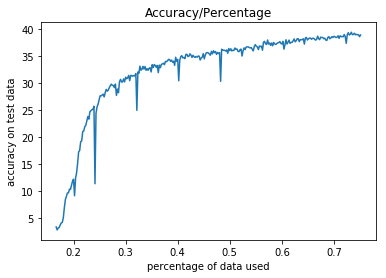

In [10]:
def random_selection(model, pool_x):
    rank = shuffle(np.arange(pool_x.shape[0]))
    return rank

try:
    with open(inline_process_template.format("learn_process_random"), 'rb') as f:
        process = pickle.load(f)
except:
    # learn function returns accuracy with respect to the percentage of data labeled
    process = learner.learn(random_selection)
    
# plot_learn_process will visualize the active learning process
plot_learn_process(process)

## 1. Uncertainty Sampling

### Least Confidence
Since the LSTM model gives probabilities of the unlabeled data belongs to each category. Least confidence selects labels that the current model has least greatest probility in determining how the unlabeled data to be categorized.
$$
x^*_{LC} = \text{argmax}_x 1 − P_\theta(y^*|x)
$$
where
$$
y* = \text{argmax}_y P_\theta(y|x)
$$

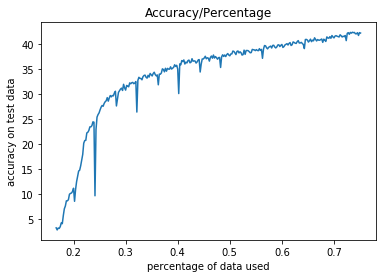

In [11]:
def confidence_selection(model, pool_x):
    scores = model.predict(pool_x)
    scores = np.max(scores, axis=1)
    rank = np.argsort(scores)
    return rank

try:
    with open(inline_process_template.format("learn_process_confidence"), 'rb') as f:
        process = pickle.load(f)
except:
    # learn function returns accuracy with respect to the percentage of data labeled
    process = learner.learn(confidence_selection)
    
# plot_learn_process will visualize the active learning process
plot_learn_process(process)

### Least Margin
Similar to the least confidence approach, we pick the unlabeled data that produces the least difference between the greatest and the second greatest probabilities.
$$
x^*_{LM} = \text{argmin}_x P_\theta(y_1|x) − P_\theta(y_2|x)
$$
where $y_1$ and $y_2$ are the most and the second most likely label

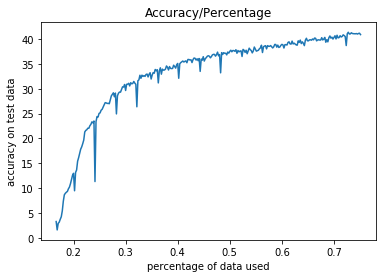

In [12]:
def margin_selection(model, pool_x):
    scores = model.predict(pool_x)
    scores_max = np.max(scores, axis=1)
    max_idx = np.argmax(scores, axis=1)
    scores[(np.arange(len(max_idx)), max_idx)] = 0
    scores_secmax = np.max(scores, axis=1)
    scores = scores_max-scores_secmax
    rank = np.argsort(scores)
    return rank

try:
    with open(inline_process_template.format("learn_process_margin"), 'rb') as f:
        process = pickle.load(f)
except:
    # learn function returns accuracy with respect to the percentage of data labeled
    process = learner.learn(margin_selection)
    
# plot_learn_process will visualize the active learning process
plot_learn_process(process)

### Greatest Entropy
Entropy quantifies the uncertainty that the model holds on an unlabeled data. This approach simply selects the labels that our current model are most uncertain about.

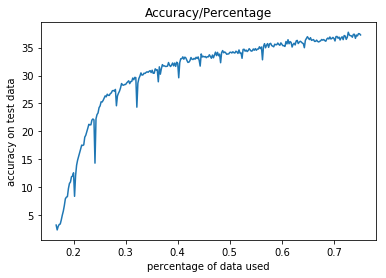

In [13]:
def entropy_selection(model, pool_x):
    scores = model.predict(pool_x)
    log_scores = -scores*np.log2(scores)
    scores = np.sum(scores, axis=1)
    rank = np.argsort(-scores)
    return rank

try:
    with open(inline_process_template.format("learn_process_entropy"), 'rb') as f:
        process = pickle.load(f)
except:
    # learn function returns accuracy with respect to the percentage of data labeled
    process = learner.learn(entropy_selection)
    
# plot_learn_process will visualize the active learning process
plot_learn_process(process)

## 2. Expected Gradient Length
Gradient quantifies how much we update the trainable weights in the model. This approach chooses the unlabeled data that will produce the greatest gradient when feed into the current model, so we choose the ones that impart the most to our model.

### Limitation
Due to the limit in computation power and memory, we modified each round of active learning such that if x data need to be selected for this round, we select this x data from a randomly shuffled subpool with 5x data instead of the whole pool.

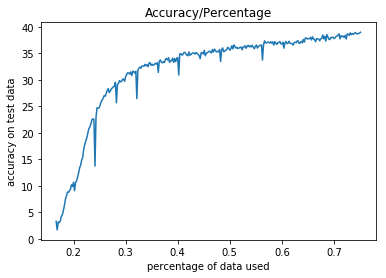

In [14]:
NUM_EGL_SELECTION = 100
def EGL_selection(model, pool_x, extra_label_per_epoch=NUM_EGL_SELECTION):
    with tf.Session() as sess:
#         print("before: ", pool_x.shape)
        sess.run(tf.global_variables_initializer())
        outputTensor = model.output
        listOfVariableTensors = model.trainable_weights
        gradients = K.gradients(outputTensor, listOfVariableTensors)
        shuffled = shuffle(np.arange(len(pool_x)))
        rnd_select = shuffled[:extra_label_per_epoch*5]
        shuffled = shuffled[extra_label_per_epoch*5:]
        scores = [-np.sum(list(map(
                     lambda x: np.linalg.norm(x), 
                     sess.run(gradients, feed_dict={model.input:(input_data.reshape(1,-1,3))})
                  ))) for input_data in list(pool_x[rnd_select])]
        selected = rnd_select[np.argsort(scores)]
        unselected = np.setdiff1d(rnd_select, selected)
#         print("after: ", np.hstack((selected, unselected, shuffled)).shape)
        return np.hstack((selected, unselected, shuffled))

try:
    with open(inline_process_template.format("learn_process_egl"), 'rb') as f:
        process = pickle.load(f)
except:
    # learn function returns accuracy with respect to the percentage of data labeled
    process = learner.learn(EGL_selection, extra_label_per_epoch=NUM_EGL_SELECTION)
    
# plot_learn_process will visualize the active learning process
plot_learn_process(process)

## 3. Submodular Function Optimization

A **submodular function** is a set function satisfying a natural diminishing returns property. We call a set
function F defined over a ground set V submodular iff for all $A \subseteq B \subseteq V$ and $v \in V \backslash B$
$$
F(A + v) − F(A) \ge F(B + v) − F(B)
$$
Basically the same thing as marginal returns in Economics.

Another simple property for the set function is that the function is monotone non-decreasing if for all $A \subseteq B \subseteq V$, $F(A) \leq F(B)$.

### Why do we need diminishing returns and monotone non-decreasing property?
Imagine you have 5 sensors and you want to properly place the sensors inside the office so that no matter which corner of the office could be on fire, on average the sensors should be able to detect the fire quickly. Another example is you have a social network relation graph of your customers, there's some costs with doing campaign for your products to one of the customers. But the characteristic of social network is that these customers may propagate information about your product to other people. The goal can be something like to using as few costs as possible while achieving campaign outcome of some measure $X$. 

The first problem is known as submodular maximization problem and the second problem is called submodular set cover problem.

It turns out both problems are NP-Hard. However if the objective function (maximizing the fire sensoring and minimizing the campaign cost in the examples above) is submodular and monotone non-decreasing, a very simple greedy algorithm can be used to approximate the optimal value. The strtegy is just for current Set $S$ with objective value of $F(S)$, we pick the element $e$ that generates the largest benefit $F(S \cup e) - F(S)$. The result get from the greedy strategy is no worse than $1-\frac{1}{e}$ times the optimal value. (A theorem proved by Nemhauser et al '78)

### Connection to active learning
The connection can be made with active learning because it is essentially a set cover problem where the goal is to minimize the labeled data put into the training data with the constraint of achieving some accuracy.

The only difference is that active learning is an adaptive version of submodular set cover problem in the sense that after one data is labeled, this newly labeled data should be included into the set when considering the data to be labeled next. 

Descibed in the paper:

http://arxiv.org/pdf/1003.3967.pdf

http://icml.cc/Conferences/2010/papers/436.pdf

The greedy algorithm is proved to have similar approximation as in the regular submodular set cover problem but with a lower bound(can perform worse when compared to optimal value).

The papers only give theoretical ideas of connecting submodular optimization with active learning but without hints to pick an proper objective submodular function. The tricky problem in this QuickDraw recognition setting, and probably in other deep neural network settings as well, is to find an objective function that measure the robustness and performance of the model with the diminishing return and monotone properties. Another thing to watch out is that when choosing unlabled data and evaluating the objective function, the actual labels of the data are unknown. 

### Some examples
There's a project: http://github.com/jmschrei/apricot that applies the submodularity on the data selection and very easy to use. The idea is to find the similarity between each pair of data and greedily select the data that are mostly different from others. Again the submodularity allows this approach to approximate relatively well while doing the job in polynomial time. However, the complexity finding the simiarity is quadratic to the size of unlabeled data. In the pool-based setting, the unlabeled pool is too big for this.

## 4. Submodularity and Graph Belief
The previous section talked about submodularity on a theoretical level and I find coming up with an objective function with the property of submodularity and monotonicity is quite hard.

This paper: http://openaccess.thecvf.com/content_cvpr_2017/papers/Paul_Non-Uniform_Subset_Selection_CVPR_2017_paper.pdf proposes an approach of constructing a graph with data as nodes to represent the relation between each pair of unlabeled data and then uses the node entropy and mutual information between each pair to construct the objective function. It is proved in the paper that the objective function is submodular and we can use submodular function minimization algorithm to efficiently solve the optimization problem.


### Create a Loopy Belief Propagation Class
This class takes in a pool of data and connects each data to the 10 nearest other data points in Euclidean distance; then runs loopy belief propagation. Since we only have pairwise edge potential here, each factor in the factor graph is just a pair of adjacent nodes. For simplicty I also added factors with only 1 node for easier calculation.

In [15]:
# Pairwise Potential Loopy Belief Propagation
class LBP:
    def __init__(self, model, data, num_classes=340, neighbour=10, iteration=2):
        self.model = model
        self.num_classes = num_classes
        self.iteration = iteration
        num_data = len(data)
        factors = set(zip([-1]*num_data, range(num_data)))
        for x in range(num_data):
            lst = self.nearest_k_neighbours(data, x, neighbour)
            for y in range(len(lst)):
                factors.add((min(x, lst[y]), max(x, lst[y])))
        factors = list(factors)
        self.factors = factors
        
        node_to_factors = [[] for _ in range(num_data)]
        order = []
        for x in range(len(factors)):
            if factors[x][0] != -1:
                order = order + [(1, factors[x][0], x), (0, x, factors[x][0])]
                node_to_factors[factors[x][0]].append(x)
            order = order + [(1, factors[x][1], x), (0, x, factors[x][1])]
            node_to_factors[factors[x][1]].append(x)
        self.order = order
        self.node_to_factors = node_to_factors
        
        self.node_po = list(model.predict(np.array(data)))
        
        num_factors = len(factors)
        self.msg_node_factor = [[np.ones(num_classes) for j in range(len(node_to_factors[i]))] for i in range(num_data)]
        self.msg_factor_node = [[np.ones(num_classes) for j in range(2)] for i in range(num_factors)]
#         print("number of factors: ", num_factors)

    def nearest_k_neighbours(self, data, x, k):
        lst = []
        for y in range(len(data)):
            if x==y:
                continue
            d = np.linalg.norm(data[x]-data[y])
            lst.append((d, y))
            for i in range(len(lst)-1, 0, -1):
                if lst[i][0] < lst[i-1][0]:
                    lst[i-1], lst[i] = lst[i], lst[i-1]
                else:
                    break
            if len(lst)>k:
                lst.pop()
        lst = [l[1] for l in lst]
        return lst
    
    def pretty_print(self, e):
        msg_node_factor = self.msg_node_factor
        msg_factor_node = self.msg_factor_node
        node_to_factors = self.node_to_factors
        factors = self.factors
        
        if e[0]==0:
            print("==========Factor to Node==========")
            print("From ", factors[e[1]], " to ", e[2])
            if(factors[e[1]][0]==e[2]):
                print(msg_factor_node[e[1]][0][:10])
                print("Sum is: ", np.sum(msg_factor_node[e[1]][0]))
            else:
                print(msg_factor_node[e[1]][1][:10])
                print("Sum is: ", np.sum(msg_factor_node[e[1]][1]))
            print("==================================")
        else:
            print("==========Node to Factor==========")
            print("From ", e[1], " to ", factors[e[2]])
            print(msg_node_factor[e[1]][node_to_factors[e[1]].index(e[2])][:10])
            print("Sum is: ", np.sum(msg_node_factor[e[1]][node_to_factors[e[1]].index(e[2])]))
            print("==================================")
            
    def converge(self):
        order = self.order
        factors = self.factors
        node_po = self.node_po
        node_to_factors = self.node_to_factors
        msg_node_factor = self.msg_node_factor
        msg_factor_node = self.msg_factor_node
        num_classes = self.num_classes
        
        edge_po_matrix = 5*np.ones((num_classes, num_classes))
        edge_po_matrix[range(num_classes), range(num_classes)] = 10
        
        for i in range(self.iteration):
#             print("Iteration ", i, ":------------------------")
            order = shuffle(order)
            for e in order:
                # factor to node
                if e[0] == 0:
                    # for factor with id e[1], (a, b), if a is the target node
                    if factors[e[1]][0] == e[2]:
                        msg_factor_node[e[1]][0] = np.dot(edge_po_matrix, msg_node_factor[factors[e[1]][1]][node_to_factors[factors[e[1]][1]].index(e[1])])
                    elif factors[e[1]][0]==-1:
                        msg_factor_node[e[1]][1] = node_po[factors[e[1]][1]]
                    # for factor with id e[1], (a, b), if b is the target node
                    else:
                        msg_factor_node[e[1]][1] = np.dot(edge_po_matrix, msg_node_factor[factors[e[1]][0]][node_to_factors[factors[e[1]][0]].index(e[1])])
                    msg_factor_node[e[1]][1] = self.normalize_msg(msg_factor_node[e[1]][1])
                    msg_factor_node[e[1]][0] = self.normalize_msg(msg_factor_node[e[1]][0])
                # node to factor
                else:
                    new_msg = np.ones(num_classes)
                    for j in node_to_factors[e[1]]:
                        if j==e[2]:
                            continue
                        if e[1] == factors[j][0]:
                            new_msg = new_msg * msg_factor_node[j][0]
                        else:
                            new_msg = new_msg * msg_factor_node[j][1]
                        new_msg = self.normalize_msg(new_msg)
                    msg_node_factor[e[1]][node_to_factors[e[1]].index(e[2])] = new_msg
#                 self.pretty_print(e)
    
    def normalize_msg(self, msg):
        s = np.sum(msg)
        if s==0:
            return msg
        else:
            return msg/s
    
    def get_belief(self):
        factors = self.factors
        msg_node_factor = self.msg_node_factor
        msg_factor_node = self.msg_factor_node
        node_to_factors = self.node_to_factors
        node_po = self.node_po
        belief = {}
        for i in range(len(factors)):
            fa = factors[i]
            if fa[0]==-1:
                belief[fa] = msg_node_factor[fa[1]][node_to_factors[fa[1]].index(i)]*node_po[fa[1]]
            else:
                belief[fa] = np.outer(msg_node_factor[fa[0]][node_to_factors[fa[0]].index(i)], msg_node_factor[fa[1]][node_to_factors[fa[1]].index(i)])
                belief[fa] = self.normalize_msg(belief[fa])
        return belief

### Optimization
In the paper, it uses Fujishige-Wolfe Min Norm Point algorithm to solve the function minimization. Because the algorithm is complex and I did not find an existing implementation of this algorithm, so I turned to the lazy greedy algorithm from the previous section hoping for a good approximation.

In [16]:
import heapq

class submodular_opt:
    def __init__(self, be, batch_pool_size):
        M = np.zeros((batch_pool_size, batch_pool_size))
        h = np.zeros(batch_pool_size)
        for k, v in be.items():
            if k[0]==-1:
                v[v==0] = 0.01
                h[k[1]] = np.sum(-v*np.log2(v))
            else:
                out = np.outer(be[(-1, k[0])], be[(-1, k[1])])
                out[out==0] = 0.01
                tmp_M = v*np.log2(v/out)
                tmp_M[np.isnan(tmp_M)] = 0
                tmp_M[tmp_M==-np.inf] = 0
                tmp_M[tmp_M==np.inf] = 0
                M[k[0], k[1]] = np.sum(tmp_M)
                M[k[1], k[0]] = np.sum(tmp_M)
        self.M = M
        self.h = h
        self.size = batch_pool_size
        self.ones = np.ones(batch_pool_size)
    
    def obj_func(self, x):
        M = self.M
        h = self.h
        ones = self.ones
        return 0.5*x.dot(-M).dot(x) + x.dot(M.dot(ones)-h)
    
    def make_x(self, lst):
        size = self.size
        zeros = np.zeros(size)
        zeros[lst] = 1
        return zeros
    
    def lazy_greedy(self, k):
        size = self.size
        selections = []
        pq = [[self.obj_func(self.make_x([i])), i, 0] for i in range(size)]
        heapq.heapify(pq)
        cur_obj = 0
        for i in range(k):
#             print(pq)
            while True:
                elem = heapq.heappop(pq)
                if len(selections) == elem[2]:
                    selections.append(elem[1])
                    cur_obj = cur_obj + elem[0]
                    break
                else:
                    elem[0] = self.obj_func(self.make_x(selections + [elem[1]])) - cur_obj
                    elem[2] = len(selections)
                    heapq.heappush(pq, elem)
        return selections

### Limitation
Same as in the expected gradient length approach, we still struggle with the memory and computation, so we use the same strategy here. Notice that by doing this, our active learning setting is very similar to the stream-based scenario.

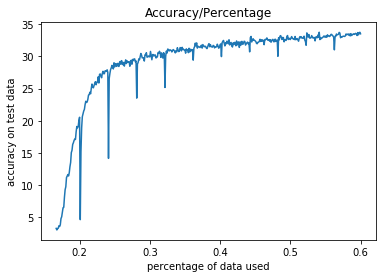

In [17]:
NUM_LOOPY_SFM_SELECTION = 100
def loopy_sfm_selection(model, pool_x, extra_label_per_epoch=NUM_LOOPY_SFM_SELECTION):
#     print(pool_x.shape)
    shuffled = shuffle(np.arange(len(pool_x)))
    rnd_select = shuffled[:extra_label_per_epoch*5]
    shuffled = shuffled[extra_label_per_epoch*5:]
    pool_x = list(pool_x[rnd_select])
    
    lbp = LBP(model, pool_x, iteration=1)
    lbp.converge()
    be = lbp.get_belief()
#     print([np.argmax(be[(-1, i)]) for i in range(extra_label_per_epoch)])
    SFM = submodular_opt(be, extra_label_per_epoch*5)
    selected = rnd_select[SFM.lazy_greedy(extra_label_per_epoch)]
#     print(selected)
    unselected = np.setdiff1d(rnd_select, selected)
#     print(np.hstack((selected, unselected, shuffled)).shape)
    return np.hstack((selected, unselected, shuffled))

try:
    with open(inline_process_template.format("learn_process_submodule"), 'rb') as f:
        process = pickle.load(f)
except:
    # learn function returns accuracy with respect to the percentage of data labeled
    process = learner.learn(EGL_selection, extra_label_per_epoch=NUM_LOOPY_SFM_SELECTION)
    
# plot_learn_process will visualize the active learning process
plot_learn_process(process)

### Some Experiment results with larger pool example

Due to applying the submodular optimization and expected gradient length approaches require long computation time. When the pool size gets larger, they become intractable and hence are not displayed on the plots below.

The following plots represent the learning processes of different active learning approaches mentioned above. The plot title shows how many training data, validation data, test data and pool data are used for each class label(there're 340 classes in total).

It seems that in the case of LSTM model for the Quick Draw game, only margin and confidence approaches are doing better most time; the other three sometimes perform worse than the random selection approach.

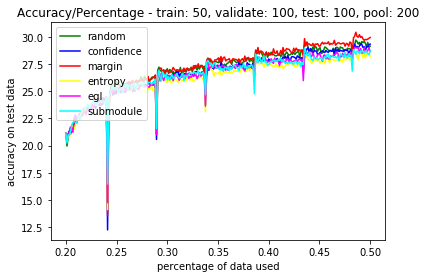

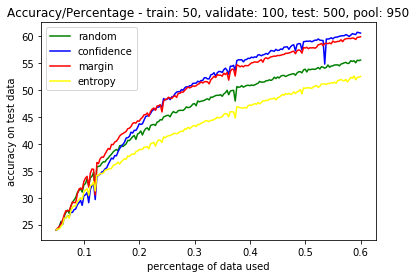

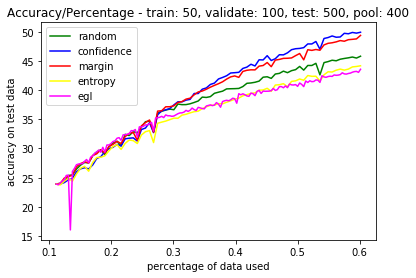

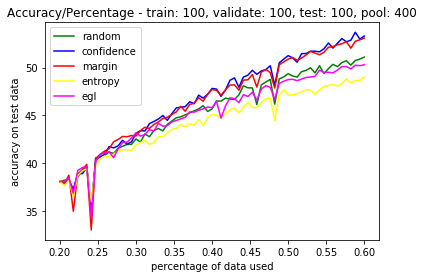

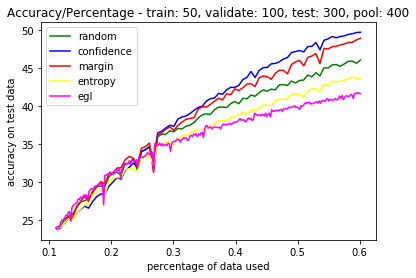

In [18]:
import re
s = "learn_process_(.+?)_"
p = re.compile(s)
process_template = "../input/learning-process/{}"
colors = ['green', 'blue', 'red', 'yellow', 'magenta', 'cyan']

def read_learning_process(filename):    
    with open(process_template.format(filename), 'rb') as f:
        content = pickle.load(f)
    return content

def plot_all_learn_process(processes, title):
    contents = [read_learning_process(process) for process in processes]
    for i in range(len(contents)):
        plt.plot(contents[i]["Percentage"], contents[i]["Accuracy"], colors[i])
    plt.title('Accuracy/Percentage'+title)
    plt.xlabel('percentage of data used')
    plt.ylabel('accuracy on test data')
    plt.legend([p.match(process).group(1) for process in processes], loc='upper left')
    plt.show()

# train, eval, test, pool
process_50_100_100_200 = ["learn_process_random_50_100_100_200", "learn_process_confidence_50_100_100_200", "learn_process_margin_50_100_100_200", "learn_process_entropy_50_100_100_200", "learn_process_egl_50_100_100_200","learn_process_submodule_50_100_100_200"]
process_50_100_500_950 = ["learn_process_random_50_100_500_950", "learn_process_confidence_50_100_500_950", "learn_process_margin_50_100_500_950", "learn_process_entropy_50_100_500_950"]
process_50_100_500_400 = ["learn_process_random_50_100_500_400", "learn_process_confidence_50_100_500_400", "learn_process_margin_50_100_500_400", "learn_process_entropy_50_100_500_400", "learn_process_egl_50_100_500_400"]
process_100_100_100_400 = ["learn_process_random_100_100_100_400", "learn_process_confidence_100_100_100_400", "learn_process_margin_100_100_100_400", "learn_process_entropy_100_100_100_400", "learn_process_egl_100_100_100_400"]
process_50_100_300_400 = ["learn_process_random_50_100_300_400", "learn_process_confidence_50_100_300_400", "learn_process_margin_50_100_300_400", "learn_process_entropy_50_100_300_400", "learn_process_egl_50_100_300_400"]

title_str = " - train: {}, validate: {}, test: {}, pool: {}"

plot_all_learn_process(process_50_100_100_200, title_str.format(50, 100, 100, 200))
plot_all_learn_process(process_50_100_500_950, title_str.format(50, 100, 500, 950))
plot_all_learn_process(process_50_100_500_400, title_str.format(50, 100, 500, 400))
plot_all_learn_process(process_100_100_100_400, title_str.format(100, 100, 100, 400))
plot_all_learn_process(process_50_100_300_400, title_str.format(50, 100, 300, 400))